In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quetzal.model import stepmodel
from quetzal.io import excel

PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.


# Validate endogenous volumes against those from VP2030

In [1]:
scenario = 'base'
manual = True
%matplotlib inline

In [3]:
input_path = '../input/'
network_path = '../input_static/'
output_path = '../output/'
model_path = '../model/' + scenario + '/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [5]:
sm = stepmodel.read_json(model_path + 'de_zones')

In [6]:
segments = [s.strip() for s in params['general']['demand_segments'].split(';')]
purposes = [s.split('_')[0] for s in segments][::2]

In [7]:
# Load old volumes
volumes_file = 'de_volumes_exo'
v = stepmodel.read_zippedpickles(model_path.replace(scenario, 'base') + volumes_file)
# Rename columns from VP2030 to match the model's demand segments
car_segment_dict = {'0': '_no_car', '1': '_car'}
vp_purpose_dict = {'Fz1': 'commuting', 'Fz2': 'education', 'Fz3': 'buy/execute',
                   'Fz4': 'business', 'Fz6': 'leisure'}
sm.volumes = v.volumes.rename(columns={
    c: vp_purpose_dict[c.split('_')[0]]+car_segment_dict[c.split('_')[-1]]
    for c in v.volumes.columns if c.startswith('Fz')
})
# Create demand segment 'accompany' from 'Fz6' (private) with MiD2017 shares
accompany_no_car_share = 101 / 1530
accompany_car_share = 5569 / 30292
sm.volumes['accompany'+car_segment_dict['0']] = \
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['0']] * accompany_no_car_share
sm.volumes['accompany'+car_segment_dict['1']] = \
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['1']] * accompany_car_share
sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['0']] = \
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['0']] * (1-accompany_no_car_share)
sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['1']] = \
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['1']] * (1-accompany_car_share)

volumes: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.22s/it]


In [8]:
# Sum of old volumes (inter-zonal)
sm.volumes.loc[sm.volumes['origin']!=sm.volumes['destination'], segments].sum().sum() / 1e9

18.79584296741475

In [9]:
# Sum of old volumes (inner-zonal)
sm.volumes.loc[sm.volumes['origin']==sm.volumes['destination'], segments].sum().sum() / 1e9

2.501294982412016

In [10]:
# Length of the OD set
od_vol = set([(o,d) for o,d in zip(sm.volumes['origin'], sm.volumes['destination'])])
len(od_vol)

4910656

In [11]:
# Load endogenously generated volumes
new = stepmodel.read_zippedpickles(model_path + 'de_volumes')

volumes: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.47s/it]


In [12]:
# Sum of new volumes
vol_sum = new.volumes.loc[new.volumes['origin']!=new.volumes['destination']
                         ].set_index(['origin', 'destination']).sum(axis=1).rename('vol')
vol_sum.sum() / 1e9

23.88660708250327

In [13]:
# Sum of new volumes (inner-zonal)
new.volumes.loc[new.volumes['origin']==new.volumes['destination'], segments].sum().sum() / 1e9

40.85894694879464

In [14]:
# Difference in OD sets
od_new = set([(o,d) for o,d in zip(new.volumes['origin'], new.volumes['destination'])])
len(od_vol - od_new)

19944

In [15]:
len(od_new)

4930600

In [16]:
# Load the calibration dataset for validation
mid2017 = pd.read_csv(input_path + 'transport_demand/calibration_all_trips_MiD2017.csv')
# Replace LAU codes with NUTS IDs
assert str(mid2017.loc[0, 'origin']).startswith('DE')
# Rename modes and purposes
mode_dict_mid = {1: 'rail_short', 2: 'rail_long',
                 3: 'coach', 4: 'bus', 5: 'air', 6: 'car', 7: 'walk'}
mid2017['mode_model'] = mid2017['mode_model'].map(mode_dict_mid)
mid2017['purpose_model'] = mid2017['purpose_model'].apply(lambda s: s.split('_')[0])
mid2017['segment'] = mid2017['purpose_model'] + mid2017['car_avail'].map(
    {1: '_car', 0: '_no_car', 9: '_no_car'})
mid2017 = mid2017[['mode_model', 'purpose_model', 'segment', 'origin', 'destination']]

In [17]:
# Load VP2030 data for validation
vp2017 = pd.read_csv(network_path + 'vp2017_validation_normalised.csv')
# Restrict to inter-cell traffic and cells of the model
vp2017 = vp2017.loc[(vp2017['origin']!=vp2017['destination']) &
                    (vp2017['origin'].notna()) &
                    (vp2017['destination'].notna())]
vp2017 = vp2017.groupby(['origin', 'destination']).sum()
mode_dict_vp = {'Bahn': 'rail', 'MIV': 'car', 'Luft': 'air', 'OESPV': 'bus', 'non': 'walk'}
vp2017.columns = pd.MultiIndex.from_tuples(
    [(col.split('_')[-1], mode_dict_vp[col.split('_')[0]]) for col in vp2017.columns],
    names=['segment', 'mode'])
# Aggregate by purpose
vp2017 = vp2017.groupby('segment', axis=1).sum().rename(columns=vp_purpose_dict)
vp2017.reset_index(inplace=True)

In [18]:
# Load distances
distances = pd.read_csv(output_path + 'distances_centroids.csv')
'''island_dict = sm.zones.loc[['outer_1', 'outer_2'], 'NUTS_ID'].to_dict()
distances['o'] = distances['origin'].replace(island_dict).str[:5]
distances['d'] = distances['destination'].replace(island_dict).str[:5]
distances_agg = distances.groupby(['o', 'd']).agg({'length': 'mean'})
distances_agg.index.set_names(['origin', 'destination'], inplace=True)
distances = distances.drop(['o', 'd'], axis=1).set_index(['origin', 'destination'])'''
distances = distances.set_index(['origin', 'destination'])

In [19]:
# Load CC, which builds the deterrence matrix for constrained distribution
#cc = pd.read_csv(output_path + scenario + '/mode_choice_od_composite_cost.csv')

## Validation

### Total volumes

In [20]:
# Inner- and inter-zonal volumes by segment
seg_df = pd.DataFrame()
seg_df['exo_inner'] = sm.volumes.loc[sm.volumes['origin']==sm.volumes['destination'],
                                     segments].sum()
seg_df['exo_inter'] = sm.volumes.loc[sm.volumes['origin']!=sm.volumes['destination'],
                                     segments].sum()
seg_df['endo_inner'] = new.volumes.loc[new.volumes['origin']==new.volumes['destination'],
                                       segments].sum()
seg_df['endo_inter'] = new.volumes.loc[new.volumes['origin']!=new.volumes['destination'],
                                       segments].sum()
# Add MiD volumes
scaler = new.volumes[segments].sum().sum() / len(mid2017)
seg_df['MiD_inner'] = mid2017.loc[mid2017['origin']==mid2017['destination']
                                 ].groupby('segment').count()['origin'].fillna(0) * scaler
seg_df['MiD_inter'] = mid2017.loc[mid2017['origin']!=mid2017['destination']
                                 ].groupby('segment').count()['origin'].fillna(0) * scaler

<AxesSubplot:>

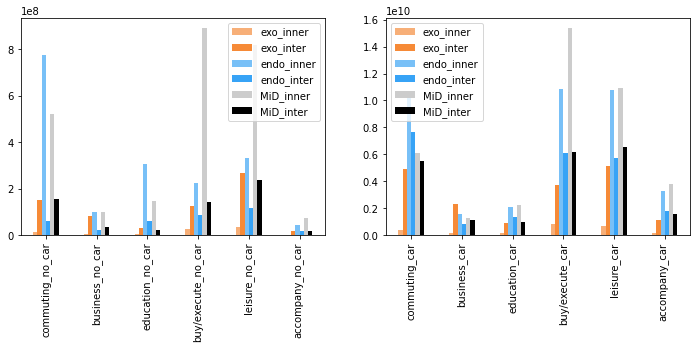

In [21]:
# Compare inner- and inter-zonal volumes by segment
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
seg_df.loc[[s for s in segments if '_no_car' in s]].plot.bar(
    legend=True, color=['#f7af78', '#f68a37', '#78c0f7', '#37a3f6', '#cccccc', '#000000'], ax=ax[0])
seg_df.loc[[s for s in segments if not '_no_car' in s]].plot.bar(
    legend=True, color=['#f7af78', '#f68a37', '#78c0f7', '#37a3f6', '#cccccc', '#000000'], ax=ax[1])

In [22]:
# Ratio of total endogenous volumes to scaled MiD volumes
(seg_df['endo_inner'] + seg_df['endo_inter']) / (seg_df['MiD_inner'] + seg_df['MiD_inter'])

commuting_no_car      1.236772
commuting_car         1.566910
business_no_car       0.909187
business_car          0.973323
education_no_car      2.129973
education_car         1.087295
buy/execute_no_car    0.299038
buy/execute_car       0.785997
leisure_no_car        0.427218
leisure_car           0.948748
accompany_no_car      0.678361
accompany_car         0.952951
dtype: float64

In [23]:
np.round(seg_df / 1e6, 1)

,exo_inner,exo_inter,endo_inner,endo_inter,MiD_inner,MiD_inter
commuting_no_car,12.2,149.7,776.0,59.7,521.7,154.0
commuting_car,398.1,4902.9,10460.7,7687.9,6066.7,5515.7
business_no_car,4.8,83.2,98.6,21.7,98.3,34.0
business_car,135.3,2329.9,1547.4,793.7,1283.9,1121.5
education_no_car,6.7,32.0,307.0,59.6,148.3,23.8
education_car,185.1,888.9,2114.3,1364.7,2243.4,956.3
buy/execute_no_car,27.6,123.5,222.6,86.3,890.5,142.3
buy/execute_car,839.2,3750.4,10851.3,6116.1,15375.4,6211.7
leisure_no_car,36.3,265.8,332.3,118.5,819.2,235.9
leisure_car,696.5,5101.6,10789.7,5766.1,10914.6,6535.6


In [24]:
# Share of inner-zonal trips in endogenous volumes
np.round(seg_df['endo_inner'] / (seg_df['endo_inter'] + seg_df['endo_inner']), 3)

commuting_no_car      0.929
commuting_car         0.576
business_no_car       0.820
business_car          0.661
education_no_car      0.838
education_car         0.608
buy/execute_no_car    0.721
buy/execute_car       0.640
leisure_no_car        0.737
leisure_car           0.652
accompany_no_car      0.728
accompany_car         0.649
dtype: float64

### Distance distribution

In [25]:
# Define distance classes
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 200, 300, 500, 1000]
labels = ['{}-{}km'.format(bins[i], bins[i+1]) for i in range(len(bins)-1)]

In [26]:
# Assign distances to volumes
for df in [new.volumes, sm.volumes, vp2017, mid2017]:#, cc]:
    if not 'bins' in df.columns:
        df['dist'] = df.set_index(['origin', 'destination']).index.map(distances.to_dict()['length'])
        df['bins'] = pd.cut(df['dist'], bins=bins, labels=labels)

In [27]:
# Look at the CC over distance by segment (builds the deterrence matrix)
#cc.loc[cc.notna().all(axis=1)].groupby('bins')[segments].mean().plot.line(
#    legend=True, figsize=(12,4), colormap='viridis', ylim=(0,30))

In [28]:
# Look at the deterrence as fed to the distribution function (roughly)
#np.power(cc.loc[cc.notna().all(axis=1)].groupby('bins')[segments].mean(), -10).plot.line(
#    legend=True, figsize=(12,4), colormap='viridis')

In [29]:
# Sum up volumes of the model and VP2030
vol_df = pd.DataFrame()
for car in car_segment_dict.values():
    segs = [s for s in segments if s.endswith(car)]
    vol_df['endo'+car] = new.volumes.groupby('bins').sum()[segs].sum(axis=1)
    vol_df['exo'+car] = sm.volumes.groupby('bins').sum()[segs].sum(axis=1)
vol_df['endo'] = new.volumes.groupby('bins').sum()[segments].sum(axis=1)
vol_df['exo'] = sm.volumes.groupby('bins').sum()[segments].sum(axis=1)

<AxesSubplot:xlabel='bins'>

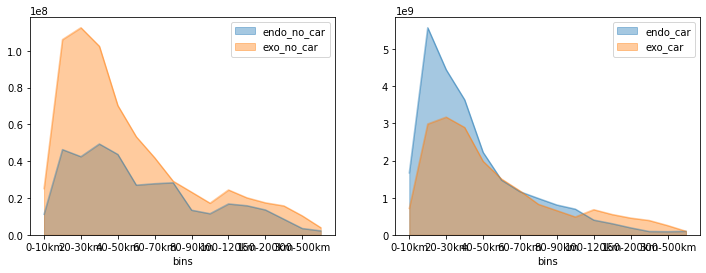

In [30]:
# plot
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
vol_df[['endo_no_car', 'exo_no_car']].plot(kind='area', stacked=False, alpha=.4, ax=ax[0])
vol_df[['endo_car', 'exo_car']].plot(kind='area', stacked=False, alpha=.4, ax=ax[1])

<AxesSubplot:xlabel='bins'>

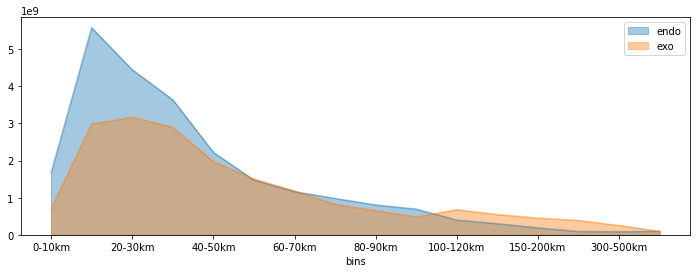

In [31]:
# plot total
vol_df[['endo', 'exo']].plot(kind='area', stacked=False, alpha=.4, figsize=(12,4))

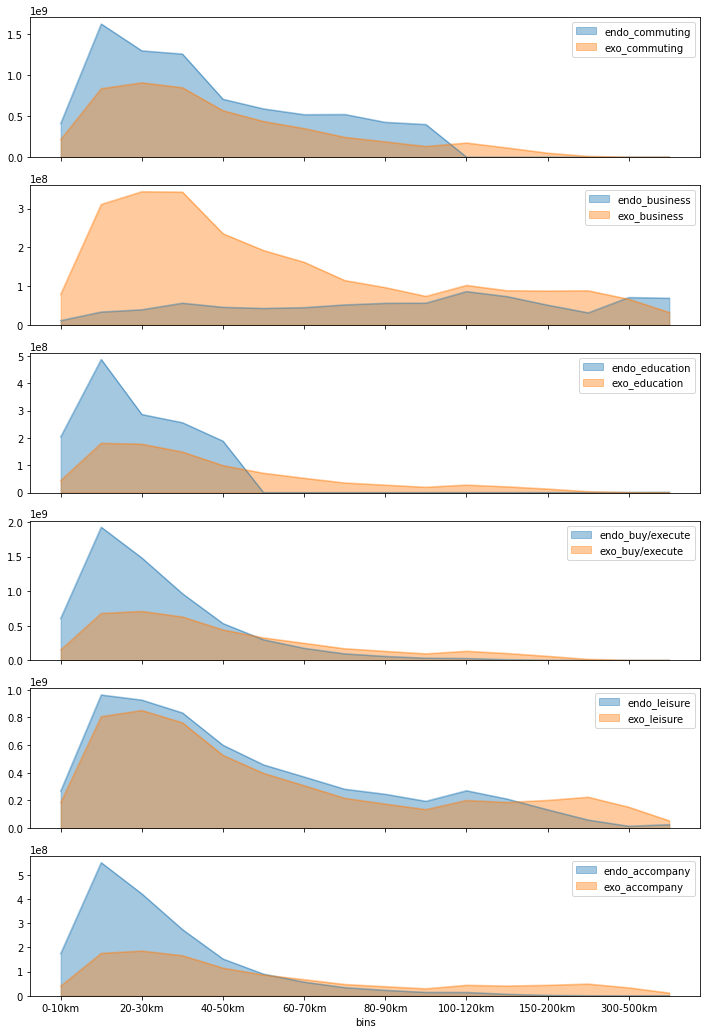

In [32]:
# plot by purpose
fig, ax = plt.subplots(ncols=1, nrows=len(purposes), figsize=(12,len(purposes)*3), sharex='all')
i = 0
for p in purposes:
    vol_df['endo_'+p] = new.volumes.groupby('bins').sum()[[s for s in segments if p in s]].sum(axis=1)
    vol_df['exo_'+p] = sm.volumes.groupby('bins').sum()[[s for s in segments if p in s]].sum(axis=1)
    vol_df[['endo_'+p, 'exo_'+p]].plot(kind='area', stacked=False, alpha=.4, ax=ax[i])
    i += 1

In [33]:
# Scale to VP2030 levels
vol_df['VP2030'] = vp2017.loc[vp2017['bins'].notna()].groupby('bins').sum()[
    ['commuting', 'education', 'buy/execute', 'business', 'leisure']
].sum(axis=1)
vol_df['endo'] /= vol_df['endo'].mean() / vol_df['VP2030'].mean()
vol_df['exo'] /= vol_df['exo'].mean() / vol_df['VP2030'].mean()

<AxesSubplot:xlabel='bins'>

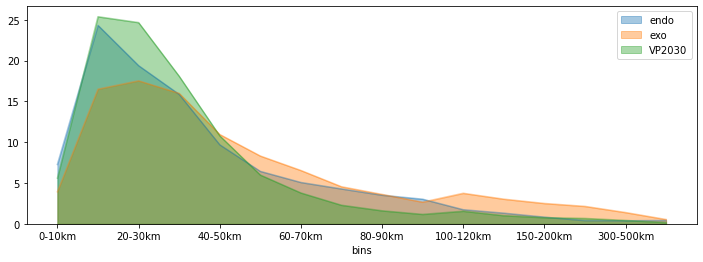

In [34]:
# plot with VP2030
vol_df[[c for c in vol_df.columns if not '_' in c]].plot(
    kind='area', stacked=False, alpha=.4, figsize=(12,4))

In [35]:
# Add MiD2017
vol_df['MiD2017'] = mid2017.loc[(mid2017['bins'].notna())
                                & (mid2017['origin']!=mid2017['destination'])
                               ].groupby('bins').size()
vol_df['MiD2017'] /= vol_df['MiD2017'].mean() / vol_df['VP2030'].mean()

<AxesSubplot:xlabel='bins'>

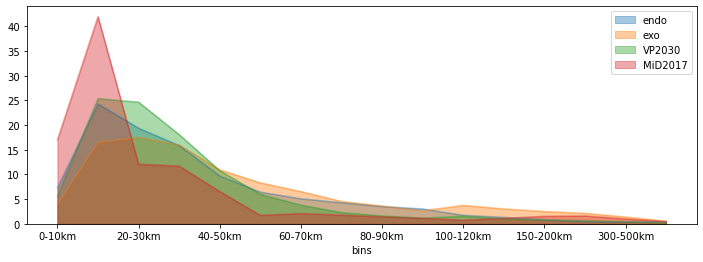

In [36]:
# plot with VP2030
vol_df[[c for c in vol_df.columns if not '_' in c]].plot(
    kind='area', stacked=False, alpha=.4, figsize=(12,4))